# An introduction to numerically solving morphogen reaction-diffusion equations
## First part of notebook provided by Prof Zena Hadjivasiliou, CELL0027, UCL
## Rest of notebook is original work by Omar Khan

You can run blocks of code either by pressing the "play" button on their left hand side, or by pressing "[shift]+[enter]" on your keyboard!

**Before the session**, try running the code cell below that should print "Notebook initialised"!

We will happily answer any questions you have about coding or the morphogen system during this session!

In [1]:
print("Notebook initialised")

Notebook initialised


First, we are going to import some Python libraries.

Libraries are collection of ready-made codes and modules that perform useful functions that make coding much simpler.

These should be all of the libraries you need to solve the problems for this course!

In [2]:
# Import Python libraries
import numpy as np # numpy is a scientific library
import matplotlib.pyplot as plt # matplotlib is a plotting library

print("Notebook initialised")

Notebook initialised


Next, we are going to set some parameters to to make our plots easy to read later on.

In [3]:
# Set global plotting parameters
plt.rcParams['figure.figsize'] = [10, 6]   # Controls default figure size (in inches)
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size = SMALL_SIZE)          # Controls default text sizes
plt.rc('axes', titlesize = SMALL_SIZE)     # Fontsize of the axes title
plt.rc('axes', labelsize = MEDIUM_SIZE)    # Fontsize of the x and y labels
plt.rc('xtick', labelsize = SMALL_SIZE)    # Fontsize of the tick labels
plt.rc('ytick', labelsize = SMALL_SIZE)    # Fontsize of the tick labels
plt.rc('legend', fontsize = SMALL_SIZE)    # Legend fontsize
plt.rc('figure', titlesize = BIGGER_SIZE)  # Fontsize of the figure title

We are going to write a code that numerically solves the reaction-diffusion equation describing the motion of morphogen molecules (as you saw in the talk earlier):

# $ \frac{\partial C(x,t)}{\partial t} = d \frac{\partial^2 C(x,t)}{\partial x^2} - k C(x,t)$

This function will accept inputs of the morphogen kinetic parameters (diffusivity and degradation rate), and numerically find the morphogen profile, $C(x,t)$, using an algorithm called the "forward Euler method". It will output the morphogen profile at steady state.

Since this is a second order partial differential equation (PDE), we need a pair of initial/boundary conditions to solve the problem.

We choose to define that the concentration is constant at $x=0$:

# $C(0,t) = C_0$,

and that there is a no flux boundary condition at the other edge of the tissue $x = L$:

# $\frac{\partial C(x,t)}{\partial x} \big|_{x=L} = 0$.

Defining our solver as a separate function means that we can call it with different input parameters to solve the morphogen system under different conditions.

In [4]:
# Define a function to solve the reaction-diffusion equation
# The boundary conditions are:
#    1) at x = 0, C = C_0;
#    2) at x = L, dC/dx = 0
def Solve(d, k, c0, L, Nx, tMax, thresholdSS):
    # d -           Diffusion coefficient
    # k -           Degradation rate
    # c0 -          Pinned concentration at x = 0
    # L -           Tissue size
    # Nx -          Number of spatial (x) gridpoints
    # tMax -        Maximum time
    # thresholdSS - Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state (SS)

    # Calculate spatial variables
    dx = L / (Nx - 1) # Spatial grid spacing

    # Define temporal variables
    dt = 1 / (k + ((4 * d) / (dx ** 2))) # Time step, from the von Neumann stability condition
    Nt = round((tMax / dt) + 1) # The maximum number of time points
    tCount = 0 # The current timestep

    # Non-dimensionalise variables
    d *= dt / (dx ** 2)
    k *= dt

    # Initialise buffer array to store the concentrations at the previous timestep
    concPrev = np.zeros(Nx)
    concPrev[0] = c0

    # Define flag to indicate when system has reached steady state (SS)
    flagSS = 0

    # Loop over time until the maximum number of time points or until the system reaches steady state (SS)
    while flagSS == 0 and tCount < Nt:

        # Update the timestep counter
        tCount += 1

        # Initialise array to store current concentration vector
        concCurr = np.zeros(Nx)

        # Update the equation
        concCurr[0] = c0
        concCurr[1:Nx - 1] = ((1 - k) * concPrev[1:Nx - 1]) + (d * (concPrev[2:Nx] + concPrev[0:Nx - 2] - (2 * concPrev[1: Nx - 1])))
        concCurr[Nx - 1] = ((1 - k) * concPrev[Nx - 1]) + (2 * d * (concPrev[Nx - 2] - concPrev[Nx - 1]))

        # Check steady state condition
        delC = sum(abs(concCurr - concPrev)) / (sum(concCurr) * dt)
        if delC < thresholdSS:
            flagSS = 1
            print("Steady state reached at t =", tCount * dt, "s")

        # Re-initialise the previous concentration vector ready for the next loop
        concPrev = np.array(concCurr)

    # Output the final concentration
    return concCurr

In order to visualise our results, we also want to plot the morphogen profiles that are outputted by our solver.

Below we define a plotting function that accepts our position (x) and concentration (y) data and returns a plot.

It also takes some extra default arguments that allow you to customise your plots.

In [5]:
# Define function to plot results
def plot(fig, ax, x, y, L, xLabel = None, yLabel = None, title = None, colour='black', figwidth = 10, figlength = 6, linewidth = 4, linestyle='-', linelabel = None):
    fig.set_size_inches(figwidth, figlength, forward = True)
    ax.plot(x, y, linewidth = linewidth, color = colour, linestyle = linestyle,label=linelabel)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_title(title)
    ax.set_xlim([0, L])
    ax.set_ylim([0,None])
    if linelabel != None:
        ax.legend()
    return fig, ax

In order to solve our morphogen system we first need to define a set of morphogen kinetic parameters to use.

Here we define some values to describe the motion of the morphogen molecules and some that describe the size of the system and the time over which we are going to solve our equations.

Test out what happens when you solve the morphogen system with different values of these parameters!

In [ ]:
# Define system parameters
d = 5             # Diffusion coefficient
k = 0.01           # Degradation rate
c0 = 5000          # Pinned concentration at x = 0
L = 100            # Tissue size

# Define simulation parameters
Nx = 201           # Number of spatial (x) gridpoints
tMax = 100000      # Maximum time
thresholdSS = 1e-8 # Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state

Finally, before we solve our system, we are going to define an analytical formula that we expect to exhibit the same behaviour as our numerical data.

The steady state solution of the reaction-diffusion defined above can be approximated in the limit of large tissue size ($L>>\lambda$):

# $ C(x) = C_0 \ e^{-x/\lambda}$

where $\lambda=\sqrt{d/k}$ is the decay length of the morphogen profile.

Using the functions we defined above, we can now solve the morphogen system and compare the numerical solution to the analytical one!

Steady state reached at t = 269.7157138394252 s
Steady state reached at t = 264.2424242424242 s
Steady state reached at t = 269.595015576324 s
Steady state reached at t = 269.7157138394252 s
Steady state reached at t = 240.0699956252734 s


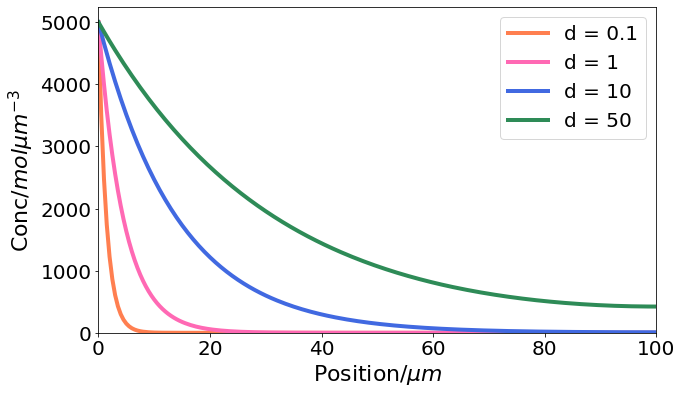

In [62]:


# Define system parameters
d = 10             # Diffusion coefficient
k = 0.05           # Degradation rate
c0 = 5000          # Pinned concentration at x = 0
L = 100            # Tissue size

# Define simulation parameters
Nx = 201           # Number of spatial (x) gridpoints
tMax = 100000      # Maximum time
thresholdSS = 1e-8 # Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state
# Calculate decay length
#lam = np.sqrt(d / k)

# Define x-axis for plotting
x = np.linspace(0, L, Nx)

# Calculate the steady state concentration
conc = Solve(d, k, c0, L, Nx, tMax, thresholdSS)

# Store analytical concentrations
#concAna = [c0 * np.exp(-x[i] / lam) for i in range(Nx)]

# Plot results
############################################################
# ORIGINAL WORK BY OMAR KHAN
############################################################
fig, ax = plt.subplots() # Initiate the figure and axes
plot(fig, ax, x, Solve(0.1, k, c0, L, Nx, tMax, thresholdSS), L, xLabel = 'Position/$\mu m$', yLabel = 'Conc/$mol \mu m^{-3}$', colour = 'coral', linelabel='d = 0.1')
plot(fig, ax, x, Solve(1, k, c0, L, Nx, tMax, thresholdSS), L, xLabel = 'Position/$\mu m$', yLabel = 'Conc/$mol \mu m^{-3}$', colour = 'hotpink', linelabel='d = 1')
plot(fig, ax, x, Solve(d, k, c0, L, Nx, tMax, thresholdSS), L, xLabel = 'Position/$\mu m$', yLabel = 'Conc/$mol \mu m^{-3}$', colour = 'royalblue', linelabel='d = 10')
plot(fig, ax, x, Solve(50, k, c0, L, Nx, tMax, thresholdSS), L, xLabel = 'Position/$\mu m$', yLabel = 'Conc/$mol \mu m^{-3}$', colour = 'seagreen', linelabel='d = 50');

#plot(fig, ax, x, concAna, L, xLabel = 'Position/$\mu m$', yLabel = 'Conc/$mol \mu m^{-3}$', colour = 'coral', linestyle = '--', linelabel = 'Analytical');

# Threshold concentrations and threshold positions

In order to investigate how morphogens can be used to pattern tissues, we will now define some functions that can extract the threshold concentrations and positions of morphogen profiles.

We assume that cells that "observe" a morphogen concentration $C(x) < C_{th}$ differentiate into a different cell type than those that "observe" a concentration $C(x) > C_{th}$.

The **threshold concentration** is defined as the concentration of a morphogen profile that generates a boundary between these two cell types at a specified position $x_{th}$.

The **threshold position** is the inverse of this, and is defined as the position of the boundary between these two cell types that arises for a specified threshold concentration.

Firstly, we will define a function to extract the threshold concentration for any position that we choose within the tissue.

We calculate the threshold concentration by iterating through the position/x-axis array until we find the index corresponding to a position that is larger than the specified threshold position.

We use this index to extract the concentration at that point from the concentration/y-axis array.

Finally, we use linear interpolation to extract the threshold concentration in case the specified threshold position is between the discrete grid points we use for our numerical analysis.

This assumes that the concentration profile in between two adjacent points is approximately a straight line.

In [6]:
# Define a function to extract the concentration corresponding to a position threshold
def findCThresh(pos, x, conc, L):
    # pos -  The threshold position
    # x -    The position (x-axis) array
    # conc - The concentration (y-axis) array
    # L -    Tissue size

    # Check if position is within domain
    if (0 < pos) and (pos < L):

        # Iterate through the x-axis array and find the index corresponding to position just above pos
        xInd = [i for i, val in enumerate(x) if val > pos]
        xInd = xInd[0]

        # Use linear interpolation to find concentration at position
        m = (conc[xInd] - conc[xInd - 1]) / (x[xInd] - x[xInd - 1]) # The gradient of the morphogen profile between the two points
        return conc[xInd] + ((pos - x[xInd]) * m)

    else:
        print("Target position is outside tissue")
        return None

Let us try running this function on a concentration profile that we find using our solver from before:

In [ ]:
# Re-define x-axis
x = np.linspace(0, L, Nx)

# Solve for new system steady state
conc = Solve(d, k, c0, L, Nx, tMax, thresholdSS)

# Calculate concentration threshold for a given position threshold
# In this case, we define the position threshold as half the tissue length
cThresh = findCThresh(32.5, x, conc, L)
print("Threshold concentration =", cThresh)

We will now define the inverse function that accepts a specified threshold concentration and returns the position at which this concentration is achieved for a morphogen profile:


In [7]:
# Define a function to extract the position corresponding to a concentration threshold (inverse of above)
def findXThresh(cThresh, x, conc):
    # cThresh - The threshold concentration
    # x -       The position (x-axis) array
    # conc -    The concentration (y-axis) array

    # Find indexes corresponding to concentrations below cThresh
    cInd = [i for i, val in enumerate(conc) if val < cThresh]

    # Check if any indexes were found
    if(len(cInd) > 0):

        # Extract index corresponding to concentration just below cThresh
        cInd = cInd[0]

        # Use linear interpolation to find concentration at position
        m = (conc[cInd] - conc[cInd - 1]) / (x[cInd] - x[cInd - 1]) # The gradient of the morphogen profile between the two points
        return x[cInd] + ((cThresh - conc[cInd]) / m)

    else:
        print("No concentrations are below the threshold")
        return None

Let's try running this function as well!

Currently this code calculates the position where the morphogen profile has a concentration of $1000 \ mol \ \mu m^{-3}$.

Try inputting the threshold concentration you found above for the threshold position of L/2.

Does the position threshold give you the result you expect?

In [ ]:
# Re-define x-axis
x = np.linspace(0, L, Nx)

# Solve for new system steady state
conc = Solve(d, k, c0, L, Nx, tMax, thresholdSS)

# Calculate position threshold
xThresh = findXThresh(500, x, conc)
print("Threshold position =", xThresh)

# Solving systems with self-enhanced degradation

We now consider a system where the morphogen molecules no longer have a constant degradation rate, and instead enhance their own degradation.

In this case, the reaction-diffusion equation we defined before becomes:

# $ \frac{\partial C(x,t)}{\partial t} = D \frac{\partial^2 C(x,t)}{\partial x^2} - k C(x,t)^2$

We need a new solver to find the steady state morphogen profile that solves this new equation.

This function uses the same general form as before: can you see what has changed? Why did it need to be changed?

In [8]:
# Define a function that finds the steady state conentration for a system with self-enhanced degradation
def SolveNonLinearDeg(d, k0, c0, Nx, tMax, L, thresholdSS):
    # d -           Diffusion coefficient
    # k -           Degradation rate
    # c0 -          Pinned concentration at x = 0
    # L -           Tissue size
    # Nx -          Number of spatial (x) gridpoints
    # tMax -        Maximum time
    # thresholdSS - Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state (SS)


    # Calculate spatial variables
    dx = L / (Nx - 1) # Spatial grid spacing

    # Define temporal variables
    dt = (1 / (((4 * d) / (dx ** 2)) + (k0 * c0))) # Time step, from a stability condition called von Neumann
    Nt = round((tMax / dt) + 1) # The maximum number of time points
    tCount = 0 # The current timestep

    # Non-dimensionalise variables
    d *= dt / (dx ** 2)
    k0 *= dt

    # Initialise buffer array to store the concentrations at the previous timestep
    concPrev = np.zeros(Nx)
    concPrev[0] = c0

    # Define flag to indicate when system has reached steady state (SS)
    flagSS = 0

    # Loop over time until the maximum number of time points or until the system reaches steady state (SS)
    while flagSS == 0 and tCount < Nt:

        # Update the timestep counter
        tCount += 1

        # Initialise array to store current concentration vector
        concCurr = np.zeros(Nx)

        # Update the equation
        concCurr[0] = c0
        concCurr[1:Nx - 1] = concPrev[1:Nx - 1] * (1 - (k0 * concPrev[1:Nx - 1])) + (d * (concPrev[2:Nx] + concPrev[0:Nx - 2] - (2 * concPrev[1:Nx - 1])))
        concCurr[Nx - 1] = concPrev[Nx - 1] * (1 - (k0 * concPrev[Nx - 1])) + (d * (concPrev[Nx - 2] - concPrev[Nx - 1]))

        # Check steady state condition
        delC = sum(abs(concCurr - concPrev)) / (sum(concCurr) * dt)
        if delC < thresholdSS:
            flagSS = 1
            print("Steady state reached at t =", tCount * dt, "s")

        # Re-initialise the previous concentration vector ready for the next loop
        concPrev = np.array(concCurr)

    # Output the final concentration
    return concCurr

Let us run this code and see what our new morphogen profile looks like!

First we need to re-define our system parameters for our new system.

Because this system has different degradation dynamics, different parameters are required for the setady state morphogen profile to exhibit a similar shape to before.

Test out what happens when you solve the morphogen system with different values of these parameters, you can even try using the same parameters we did for the case of constant degradation!

In [ ]:
# Define different system parameters for the system with self enhanced degradation
d = 5              # Diffusion coefficient
k0 = 0.00005       # Degradation rate prefactor
c0 = 5000          # Pinned concentration at x = 0
L = 100            # Tissue size

# Define simulation parameters
Nx = 201           # Number of spatial (x) gridpoints
tMax = 100000      # Maximum time
thresholdSS = 1e-8 # Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state

Now we can pass these parameters to our new solver just like we did last time!

In [ ]:
# Re-define x-axis
x = np.linspace(0, L, Nx)

# Calculate the steady state concentration
conc = SolveNonLinearDeg(d, k0, c0, Nx, tMax, L, thresholdSS)
# Calculate the steady state concentration
conclin = Solve(d, k, c0, L, Nx, tMax, thresholdSS)

# Store analytical concentrations
concAna = [c0 * np.exp(-x[i] / lam) for i in range(Nx)]

# Plot results
fig, ax = plt.subplots() # Initiate the figure and axes
plot(fig, ax, x, conclin, L, xLabel = 'Position/$\mu m$', yLabel = 'Conc/$mol \mu m^{-3}$', colour = 'royalblue', linelabel = 'Numerical')
plot(fig, ax, x, concAna, L, xLabel = 'Position/$\mu m$', yLabel = 'Conc/$mol \mu m^{-3}$', colour = 'coral', linestyle = '--', linelabel = 'Analytical')
plot(fig, ax, x, conc, L, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'hotpink', linelabel = 'nonlinear');

You can use the same code as we did for the case of constant degradation to calculate the concentration and position thresholds of these new morphogen profiles as well!

You can add new "code cells" to this notebook by pressing the "+ Code" button in the top left corner of the notebook, by hovering your mouse below the centre of this text box and pressing the "+ Code" button that appears, or by pressing "[ctrl]+m+b" on your keyboard!

Let us know if you have any more questions!

# The rest of the notebook is original work by Omar Khan
## CELL0027 Week 7 Exercises - 26/02/2024

Steady state reached at t = 269.7157138394252 s


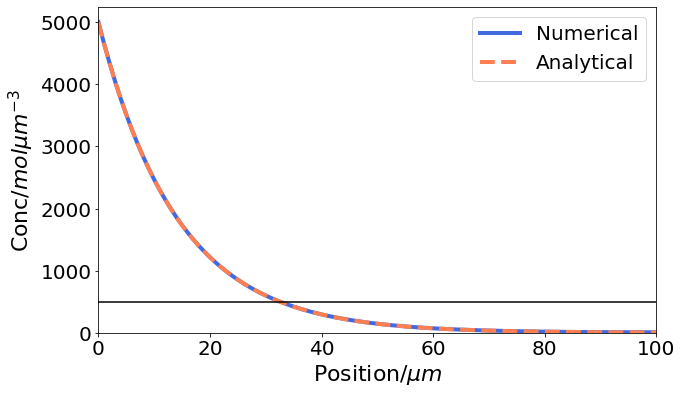

For concentration 500 mol um-3, the position is 32.563470670302934
Threshold position according to the provided function findXThresh = 32.56719383513664


In [12]:
#############################################
## QUESTION 1
#############################################

import math

# Define system parameters according to question
d = 10             # Diffusion coefficient
k = 0.05           # Degradation rate
c0 = 5000          # Pinned concentration at x = 0
L = 100            # Tissue size

# Define simulation parameters as already provided
Nx = 201           # Number of spatial (x) gridpoints
tMax = 100000      # Maximum time
thresholdSS = 1e-8 # Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state

lam = np.sqrt(d / k)      # Calculate decay length
x = np.linspace(0, L, Nx) # Define x-axis for plotting
conc = Solve(d, k, c0, L, Nx, tMax, thresholdSS) # Calculate the steady state concentration
concAna = [c0 * np.exp(-x[i] / lam) for i in range(Nx)] # Store analytical concentrations
fig, ax = plt.subplots() # Initiate the figure and axes
plot(fig, ax, x, conc, L, xLabel = 'Position/$\mu m$', yLabel = 'Conc/$mol \mu m^{-3}$', colour = 'royalblue', linelabel = 'Numerical')
plot(fig, ax, x, concAna, L, xLabel = 'Position/$\mu m$', yLabel = 'Conc/$mol \mu m^{-3}$', colour = 'coral', linestyle = '--', linelabel = 'Analytical');
plt.axhline(500,color='k') # ORIGINAL
plt.show() # ORIGINAL

# ORIGINAL FUNCTION THAT SOLVES IT ANALYTICALLY
def find_pos(d, k, c0, threshold):  
    lam = np.sqrt(d/k)
    x = - lam * math.log(threshold/c0)
    return x

x1 = find_pos(d, k, c0, 500)
print(f'For concentration 500 mol um-3, the position is {x1}')

# VERIFICATION USING PROVIDED FUNCTION
xThresh = findXThresh(500, x, conc)
print("Threshold position according to the provided function findXThresh =", xThresh)

In [ ]:
#############################################
## QUESTION 2
#############################################

x = np.linspace(0, L, Nx) # From question 1
conc = Solve(d, k, c0, L, Nx, tMax, thresholdSS) 
xThresh = findXThresh(500, x, conc)

# Defining the "true" ratio
ratio_true = xThresh / (100 - xThresh)

# Varying c0 by 20%
conc_up = Solve(d,k,1.2*c0,L,Nx,tMax,thresholdSS)
x_up = findXThresh(500,x,conc_up)
ratio_up = x_up / (100 - x_up)

conc_down = Solve(d,k,0.8*c0,L,Nx,tMax,thresholdSS)
x_down = findXThresh(500,x,conc_down)
ratio_down = x_down / (100 - x_down)

# Percentage errors
print(f'The "true" ratio is {ratio_true}')
print(f'For c0 increased by 20%, the percentage error is {100*(abs(ratio_up - ratio_true)/ratio_true)}%')
print(f'For c0 decreased by 20%, the percentage error is {100*(abs(ratio_down - ratio_true)/ratio_true)}%')

In [ ]:
#############################################
## QUESTION 3
#############################################

# Define different system parameters for the system with self enhanced degradation according to the question
d_ = 10              # Diffusion coefficient
k0_ = 0.00005       # Degradation rate prefactor
c0_ = 5000          # Pinned concentration at x = 0
L_ = 100            # Tissue size

# Define simulation parameters
Nx_ = 201           # Number of spatial (x) gridpoints
tMax_ = 100000      # Maximum time
thresholdSS_ = 1e-8 # Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state

x_new = np.linspace(0, L_, Nx_) # Re-define x-axis
conc_new = SolveNonLinearDeg(d_, k0_, c0_, Nx_, tMax_, L_, thresholdSS_) # Calculate the steady state concentration

############################################
##### NEW WORK FOR ADDITIONAL PARTS
############################################
# Plotting C and epsilon
epsilon = 1/(((k0_*c0_)/(6*d_))**(0.5))
A = (6*d_)/k0_
C = A/((x_new+epsilon)**2)
fig, ax = plt.subplots()
plot(fig, ax, x_new, conc_new, L_, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'hotpink', linelabel = 'Numerical')
plt.plot(x,C,color='cyan',linestyle='--',label='C = A/((x+epsilon)**2)')
plt.legend()
plt.show()

############################################## Repeating Q2
xThresh2 = findXThresh(500, x_new, conc_new)
print("Threshold position according to the provided function findXThresh =", xThresh)

# Defining the "true" ratio
ratio_true2 = xThresh2 / (100 - xThresh2)

# Varying c0 by 20%
conc_up2 = SolveNonLinearDeg(d_, k0_, 1.2*c0_, Nx_, tMax_, L_, thresholdSS_)
x_up2 = findXThresh(500,x_new,conc_up2)
ratio_up2 = x_up2 / (100 - x_up2)

conc_down2 = SolveNonLinearDeg(d_, k0_, 0.8*c0_, Nx_, tMax_, L_, thresholdSS_)
x_down2 = findXThresh(500,x_new,conc_down2)
ratio_down2 = x_down2 / (100 - x_down2)

# Percentage errors
print(f'The "true" ratio is {ratio_true2}')
print(f'For c0 increased by 20%, the percentage error is {100*(abs(ratio_up2 - ratio_true2)/ratio_true2)}%')
print(f'For c0 decreased by 20%, the percentage error is {100*(abs(ratio_down2 - ratio_true2)/ratio_true2)}%')

In [ ]:
findCThresh(20, x_new, conc_new, 100)

In [ ]:
#############################################
## QUESTION 4
#############################################

# Define system parameters according to question
d_linear = 10             # Diffusion coefficient
k_linear = 0.05           # Degradation rate
c0_linear = 5000          # Pinned concentration at x = 0
L_all = 100            # Tissue size

# Define different system parameters for the system with self enhanced degradation according to question
d_self = 10              # Diffusion coefficient
k0_self = 0.00005       # Degradation rate prefactor
c0_self = 5000          # Pinned concentration at x = 0

# Define simulation parameters as already provided
Nx = 201           # Number of spatial (x) gridpoints
tMax = 100000      # Maximum time
thresholdSS = 1e-8 # Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state

# What is the "true" threshold position?
x_all = np.linspace(0, L_all, Nx) # From question 1
conc_linear = Solve(d_linear, k_linear, c0_linear, L_all, Nx, tMax, thresholdSS) 
xThresh_linear_true = findXThresh(500, x_all, conc_linear)
conc_selfen = SolveNonLinearDeg(d_self, k0_self, c0_self, Nx, tMax, L_all, thresholdSS)
xThresh_selfen_true = findXThresh(500,x_all,conc_selfen)

linear_percent_error = []
selfen_percent_error = []
for i in np.arange(0.5,1.6,0.1):
    conc_linear = Solve(d_linear, k_linear, i*c0_linear, L_all, Nx, tMax, thresholdSS) 
    xThresh_linear = findXThresh(500, x_all, conc_linear)
    conc_selfen = SolveNonLinearDeg(d_self, k0_self, i*c0_self, Nx, tMax, L_all, thresholdSS)
    xThresh_selfen = findXThresh(500,x_all,conc_selfen)
    linear_percent_error.append(100*(abs(xThresh_linear - xThresh_linear_true)/xThresh_linear_true))
    selfen_percent_error.append(100*(abs(xThresh_selfen - xThresh_selfen_true)/xThresh_selfen_true))

plt.figure(figsize=(12,10))
plt.plot(np.arange(-50,60,10), linear_percent_error, 'g', label='Linear')
plt.plot(np.arange(-50,60,10), selfen_percent_error, 'r', label='Self-enhanced')
plt.xlabel('Percentage change in c0')
plt.ylabel('Percentage error in threshold position, xth')
plt.legend()
plt.show()

In [ ]:
#############################################
## QUESTION 5 - thresholds
#############################################

# Define system parameters according to question
d_linear2 = 10             # Diffusion coefficient
k_linear2 = 0.05           # Degradation rate
c0_linear2 = 5000          # Pinned concentration at x = 0
L_all2 = 100            # Tissue size

# Define different system parameters for the system with self enhanced degradation according to question
d_self2 = 10              # Diffusion coefficient
k0_self2 = 0.00005       # Degradation rate prefactor
c0_self2 = 5000          # Pinned concentration at x = 0

# Define simulation parameters as already provided
Nx = 201           # Number of spatial (x) gridpoints
tMax = 100000      # Maximum time
thresholdSS = 1e-8 # Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state

x_all2 = np.linspace(0, L_all2, Nx) # From question 1

def peturb(threshold):
    #threshold_linear = findCThresh(position, x_all2, )
    linear_percent_error2 = []
    linear_conc = Solve(d_linear2, k_linear2, c0_linear2, L_all2, Nx, tMax, thresholdSS)
    linear_truex = findXThresh(threshold, x_all2, linear_conc)
    for j in np.arange(0.5,1.6,0.1):
        linear_conc_i = Solve(d_linear2, k_linear2, j*c0_linear2, L_all2, Nx, tMax, thresholdSS)
        linear_ix = findXThresh(threshold, x_all2, linear_conc_i)
        linear_percent_error2.append(100*(abs(linear_ix - linear_truex)/linear_truex))
        
    selfen_percent_error2 = []
    selfen_conc = SolveNonLinearDeg(d_self2, k0_self2, c0_self2, Nx, tMax, L_all2, thresholdSS)
    selfen_truex = findXThresh(threshold, x_all2, selfen_conc)
    for q in np.arange(0.5,1.6,0.1):
        selfen_conc_i = SolveNonLinearDeg(d_self2, k0_self2, q*c0_self2, Nx, tMax, L_all2, thresholdSS)
        selfen_ix = findXThresh(threshold, x_all2, selfen_conc_i)
        print(selfen_ix)
        selfen_percent_error2.append(100*(abs(selfen_ix - selfen_truex)/selfen_truex))
    
    return linear_percent_error2, selfen_percent_error2, linear_truex, selfen_truex

fig, ax = plt.subplots(1, 2, figsize=(19, 8))
ax[0].plot(np.arange(-50,60,10), peturb(500)[0], label=f'x_th = {int(peturb(500)[2])}')
ax[0].plot(np.arange(-50,60,10), peturb(1000)[0], label=f'x_th = {int(peturb(1000)[2])}')
ax[0].plot(np.arange(-50,60,10), peturb(2000)[0], label=f'x_th = {int(peturb(2000)[2])}')
ax[0].plot(np.arange(-50,60,10), peturb(2500)[0], label=f'x_th = {int(peturb(2500)[2])}')
ax[1].plot(np.arange(-50,60,10), peturb(500)[1], label=f'x_th = {int(peturb(500)[3])}')
ax[1].plot(np.arange(-50,60,10), peturb(1000)[1], label=f'x_th = {int(peturb(1000)[3])}')
ax[1].plot(np.arange(-50,60,10), peturb(2000)[1], label=f'x_th = {int(peturb(2000)[3])}')
ax[1].plot(np.arange(-50,60,10), peturb(2500)[1], label=f'x_th = {int(peturb(2500)[3])}')
ax[1].legend()
ax[0].set_xlabel('Percentage change in c0')
ax[1].set_xlabel('Percentage change in c0')
ax[0].set_ylabel('Percentage error in threshold position, xth')
ax[1].set_ylabel('Percentage error in threshold position, xth')
ax[0].set_title('Linear degradation rate')
ax[1].set_title('Self-enhanced degradation rate')
plt.suptitle('Changing the threshold')
plt.show()

In [9]:
#############################################
## QUESTION 5 - new self-enhanced relation
#############################################

# Define a **NEW** function that finds the steady state conentration for a system with self-enhanced degradation
def SolveNewExponentNonLinear(d, k0, c0, Nx, tMax, L, thresholdSS, q):
    # d -           Diffusion coefficient
    # k -           Degradation rate
    # c0 -          Pinned concentration at x = 0
    # L -           Tissue size
    # Nx -          Number of spatial (x) gridpoints
    # tMax -        Maximum time
    # thresholdSS - Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state (SS)
    # q -           Exponent

    # Calculate spatial variables
    dx = L / (Nx - 1) # Spatial grid spacing

    # Define temporal variables
    dt = (1 / (((4 * d) / (dx ** 2)) + (k0 * (c0**q)))) # Time step, from a stability condition called von Neumann
    Nt = round((tMax / dt) + 1) # The maximum number of time points
    tCount = 0 # The current timestep

    # Non-dimensionalise variables
    d *= dt / (dx ** 2)
    k0 *= dt

    # Initialise buffer array to store the concentrations at the previous timestep
    concPrev = np.zeros(Nx)
    concPrev[0] = c0

    # Define flag to indicate when system has reached steady state (SS)
    flagSS = 0

    # Loop over time until the maximum number of time points or until the system reaches steady state (SS)
    while flagSS == 0 and tCount < Nt:

        # Update the timestep counter
        tCount += 1

        # Initialise array to store current concentration vector
        concCurr = np.zeros(Nx)

        # Update the equation
        concCurr[0] = c0
        concCurr[1:Nx - 1] = concPrev[1:Nx - 1] * (1 - (k0 * (concPrev[1:Nx - 1]**q))) + (d * (concPrev[2:Nx] + concPrev[0:Nx - 2] - (2 * concPrev[1:Nx - 1])))
        concCurr[Nx - 1] = concPrev[Nx - 1] * (1 - (k0 * (concPrev[Nx - 1]**q))) + (d * (concPrev[Nx - 2] - concPrev[Nx - 1]))

        # Check steady state condition
        delC = sum(abs(concCurr - concPrev)) / (sum(concCurr) * dt)
        if delC < thresholdSS:
            flagSS = 1
            print("Steady state reached at t =", tCount * dt, "s")

        # Re-initialise the previous concentration vector ready for the next loop
        concPrev = np.array(concCurr)

    # Output the final concentration
    return concCurr

In [ ]:
# Define different system parameters for the system with self enhanced degradation according to the question
d_ = 10              # Diffusion coefficient
k0_ = 0.00005       # Degradation rate prefactor
c0_ = 500          # Pinned concentration at x = 0
L_ = 100            # Tissue size
q = 2

# Define simulation parameters
Nx_ = 201           # Number of spatial (x) gridpoints
tMax_ = 100000      # Maximum time
thresholdSS_ = 1e-8 # Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state

x_new = np.linspace(0, L_, Nx_) # Re-define x-axis
conc_new = SolveNonLinearDeg(d_, k0_, c0_, Nx_, tMax_, L_, thresholdSS_) # Calculate the steady state concentration
conc_newer = SolveNewExponentNonLinear(d_, k0_, c0_, Nx_, tMax_, L_, thresholdSS_, q)
conc_even_newer = SolveNewExponentNonLinear(d_, k0_, c0_, Nx_, tMax_, L_, thresholdSS_, 3)
#conc_no = SolveNewExponentNonLinear(d_, k0_, c0_, Nx_, tMax_, L_, thresholdSS_, -1)

fig, ax = plt.subplots()
plot(fig, ax, x_new, conc_new, L_, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'hotpink', linelabel = 'k=k0*C')
plot(fig, ax, x_new, conc_newer, L_, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'seagreen', linelabel = 'k=k0*C^q, q=2')
plot(fig, ax, x_new, conc_even_newer, L_, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'cyan', linelabel = 'k=k0*C^q, q=3')
#plot(fig, ax, x_new, conc_no, L_, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'cyan', linelabel = 'k=k0*C^q, q=-1')
#plt.plot(x,C,color='c',label='C = A/((x+epsilon)**2)')
plt.legend()
plt.show()

In [ ]:
#############################################
## QUESTION 4 - percentage changes in C0
#############################################

# Adapted from q4 code
# Define system parameters according to question
d_linear = 10             # Diffusion coefficient
k_linear = 0.05           # Degradation rate
c0_linear = 5000          # Pinned concentration at x = 0
L_all = 100            # Tissue size

# Define different system parameters for the system with self enhanced degradation according to question
d_self = 10              # Diffusion coefficient
k0_self = 0.00005       # Degradation rate prefactor
c0_self = 5000          # Pinned concentration at x = 0

# Define simulation parameters as already provided
Nx = 201           # Number of spatial (x) gridpoints
tMax = 100000      # Maximum time
thresholdSS = 1e-8 # Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state

# What is the "true" threshold position?
x_all = np.linspace(0, L_all, Nx) # From question 1
conc_linear = Solve(d_linear, k_linear, c0_linear, L_all, Nx, tMax, thresholdSS) 
xThresh_linear_true = findXThresh(500, x_all, conc_linear)
conc_selfen = SolveNonLinearDeg(d_self, k0_self, c0_self, Nx, tMax, L_all, thresholdSS)
xThresh_selfen_true = findXThresh(500,x_all,conc_selfen)

conc_linear_up25 = Solve(d_linear, k_linear, 1.2*c0_linear, L_all, Nx, tMax, thresholdSS)
conc_linear_down25 = Solve(d_linear, k_linear, 0.8*c0_linear, L_all, Nx, tMax, thresholdSS)
#conc_linear_up35 = Solve(d_linear, k_linear, 1.35*c0_linear, L_all, Nx, tMax, thresholdSS)
#conc_linear_down35 = Solve(d_linear, k_linear, 0.65*c0_linear, L_all, Nx, tMax, thresholdSS)
conc_linear_up50 = Solve(d_linear, k_linear, 1.5*c0_linear, L_all, Nx, tMax, thresholdSS)
conc_linear_down50 = Solve(d_linear, k_linear, 0.5*c0_linear, L_all, Nx, tMax, thresholdSS)
#conc_selfen_up = SolveNonLinearDeg(d_self, k0_self, 1.2*c0_self, Nx, tMax, L_all, thresholdSS)

In [ ]:
fig, ax = plt.subplots()
plot(fig, ax, x_all, conc_linear_up50, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'red', linelabel = 'c0+50%')
plot(fig, ax, x_all, conc_linear_up25, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'forestgreen', linelabel = 'c0+20%')
#plot(fig, ax, x_all, conc_linear_up20, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'gold', linelabel = 'c0+20%')
plot(fig, ax, x_all, conc_linear, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'royalblue', linelabel = 'Baseline')
plot(fig, ax, x_all, conc_linear_down25, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'gold', linelabel = 'c0-20%')
plot(fig, ax, x_all, conc_linear_down50, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'purple', linelabel = 'c0-50%');
#plot(fig, ax, x_all, conc_linear_down50, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'magenta', linelabel = 'c0-50%');

In [ ]:
#############################################
## QUESTION 5 - changing the threshold
#############################################

# Adapted from earlier
# Define system parameters according to question
d_linear3 = 10             # Diffusion coefficient
k_linear3 = 0.05           # Degradation rate
c0_linear3 = 5000          # Pinned concentration at x = 0
L_all3 = 100            # Tissue size

# Define different system parameters for the system with self enhanced degradation according to question
d_self3 = 10              # Diffusion coefficient
k0_self3 = 0.00005       # Degradation rate prefactor
c0_self3 = 5000          # Pinned concentration at x = 0

# Define simulation parameters as already provided
Nx = 201           # Number of spatial (x) gridpoints
tMax = 100000      # Maximum time
thresholdSS = 1e-8 # Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state

x_all3 = np.linspace(0, L_all2, Nx) # From question 1

conc_linear3 = Solve(d_linear3, k_linear3, c0_linear3, L_all3, Nx, tMax, thresholdSS)
conc_selfen3 = SolveNonLinearDeg(d_self3, k0_self3, c0_self3, Nx, tMax, L_all3, thresholdSS)
xThresh_linear_true3 = findXThresh(500, x_all3, conc_linear3)
xThresh_selfen_true3 = findXThresh(500, x_all3, conc_selfen3)
linear_percent_error3 = []
selfen_percent_error3 = []
for i in np.arange(0.5,1.55,0.05):
    conc_linear4 = Solve(d_linear3, k_linear3, i*c0_linear3, L_all3, Nx, tMax, thresholdSS) 
    xThresh_linear = findXThresh(500, x_all3, conc_linear4)
    conc_selfen4 = SolveNonLinearDeg(d_self3, k0_self3, i*c0_self3, Nx, tMax, L_all3, thresholdSS)
    xThresh_selfen = findXThresh(500,x_all,conc_selfen4)
    linear_percent_error3.append(100*(abs(xThresh_linear - xThresh_linear_true3)/xThresh_linear_true3))
    selfen_percent_error3.append(100*(abs(xThresh_selfen - xThresh_selfen_true3)/xThresh_selfen_true3))

In [ ]:
#fig, ax = plt.subplots()
#plot(fig, ax, x_all3, conc_linear3[0], L_all3, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', title='Changing c0', colour = 'royalblue', linelabel = 'Baseline')
#plot(fig, ax, x_all3, conc_linear3[1], L_all3, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'seagreen', linelabel = 'c0+20%')
#plot(fig, ax, x_all3, conc_linear3[2], L_all3, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'gold', linelabel = 'c0-20%')
#plot(fig, ax, x_all3, conc_linear3[3], L_all3, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'red', linelabel = 'c0+50%')
#plot(fig, ax, x_all3, conc_linear3[4], L_all3, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'purple', linelabel = 'c0-50%');
#ax.axhline(y=1000, color='k', ls='-', label='Threshold')
#ax.set_title('Changing c0 with linear degradation')

#fig1, ax1 = plt.subplots()
#plot(fig1, ax1, x_all3, conc_selfen3[0], L_all3, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', title='Changing c0 with self-enhanced degradation', colour = 'royalblue', linelabel = 'Baseline')
#plot(fig1, ax1, x_all3, conc_selfen3[1], L_all3, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'seagreen', linelabel = 'c0+20%')
#plot(fig1, ax1, x_all3, conc_selfen3[2], L_all3, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'gold', linelabel = 'c0-20%')
#plot(fig1, ax1, x_all3, conc_selfen3[3], L_all3, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'red', linelabel = 'c0+50%')
#plot(fig1, ax1, x_all3, conc_selfen3[4], L_all3, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'purple', linelabel = 'c0-50%');
#ax1.axhline(y=1000, color='k', ls='-', label='Threshold')
#ax1.set_title('Changing c0 with self-enhanced degradation')

plt.figure(figsize=(12,10))
plt.plot(np.arange(-50,55,5), linear_percent_error3, marker='o', markersize=10, color='forestgreen', linestyle='dashed', linewidth=2.5, label='Linear')
plt.plot(np.arange(-50,55,5), selfen_percent_error3, marker='o', markersize=10, color='orangered', linestyle='dashed', linewidth=2.5, label='Self-enhanced')
plt.xlabel('Percentage change in c0')
plt.ylabel('Percentage error in threshold position, xth')
plt.title(f'Concentration threshold = 500, baseline x_th = {int(xThresh_linear_true3)}')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
conc_linear3 = [Solve(d_linear3, k_linear3, c0_linear3, L_all3, Nx, tMax, thresholdSS),
                Solve(d_linear3, k_linear3, 1.2*c0_linear3, L_all3, Nx, tMax, thresholdSS),
                Solve(d_linear3, k_linear3, 0.8*c0_linear3, L_all3, Nx, tMax, thresholdSS),
                Solve(d_linear3, k_linear3, 1.5*c0_linear3, L_all3, Nx, tMax, thresholdSS),
                Solve(d_linear3, k_linear3, 0.5*c0_linear3, L_all3, Nx, tMax, thresholdSS)]
#conc_selfen3 = [SolveNonLinearDeg(d_self3, k0_self3, c0_self3, Nx, tMax, L_all3, thresholdSS),
#                SolveNonLinearDeg(d_self3, k0_self3, 1.2*c0_self3, Nx, tMax, L_all3, thresholdSS),
#                SolveNonLinearDeg(d_self3, k0_self3, 0.8*c0_self3, Nx, tMax, L_all3, thresholdSS),
#                SolveNonLinearDeg(d_self3, k0_self3, 1.5*c0_self3, Nx, tMax, L_all3, thresholdSS),
#                SolveNonLinearDeg(d_self3, k0_self3, 0.5*c0_self3, Nx, tMax, L_all3, thresholdSS)]

fig, ax = plt.subplots()
plot(fig, ax, x_all3, conc_linear3[0], L_all3, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', title='Changing c0', colour = 'royalblue', linelabel = 'Baseline')
plot(fig, ax, x_all3, conc_linear3[1], L_all3, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'seagreen', linelabel = 'c0+20%')
plot(fig, ax, x_all3, conc_linear3[2], L_all3, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'gold', linelabel = 'c0-20%')
plot(fig, ax, x_all3, conc_linear3[3], L_all3, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'red', linelabel = 'c0+50%')
plot(fig, ax, x_all3, conc_linear3[4], L_all3, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'purple', linelabel = 'c0-50%');
ax.axhline(y=250, color='k', ls='-', label='Threshold')
#ax.set_title('Changing c0 with linear degradation')

In [ ]:
#################################################
## QUESTION 5 - introducing a second threshold
#################################################

x = np.linspace(0, L, Nx) # From question 1
conc = Solve(d, k, c0, L, Nx, tMax, thresholdSS) 
xThresh = findXThresh(500, x, conc)

# Defining the "true" ratio
ratio_true = xThresh / (100 - xThresh)

# Varying c0 by 20%
conc_up = Solve(d,k,1.2*c0,L,Nx,tMax,thresholdSS)
x_up = findXThresh(500,x,conc_up)
ratio_up = x_up / (100 - x_up)

conc_down = Solve(d,k,0.8*c0,L,Nx,tMax,thresholdSS)
x_down = findXThresh(500,x,conc_down)
ratio_down = x_down / (100 - x_down)

# Percentage errors
print(f'The "true" ratio is {ratio_true}')
print(f'For c0 increased by 20%, the percentage error is {100*(abs(ratio_up - ratio_true)/ratio_true)}%')
print(f'For c0 decreased by 20%, the percentage error is {100*(abs(ratio_down - ratio_true)/ratio_true)}%')

In [ ]:
#################################################
## QUESTION 4 - explaining the asymmetry
#################################################

# Define system parameters according to question
d_linear = 10             # Diffusion coefficient
k_linear = 0.05           # Degradation rate
c0_linear = 5000          # Pinned concentration at x = 0
L_all = 100            # Tissue size

# Define different system parameters for the system with self enhanced degradation according to question
d_self = 10              # Diffusion coefficient
k0_self = 0.00005       # Degradation rate prefactor
c0_self = 5000          # Pinned concentration at x = 0

# Define simulation parameters as already provided
Nx = 201           # Number of spatial (x) gridpoints
tMax = 100000      # Maximum time
thresholdSS = 1e-8 # Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state

# What is the "true" threshold position?
x_all = np.linspace(0, L_all, Nx) # From question 1
conc_linear6 = Solve(d_linear, k_linear, c0_linear, L_all, Nx, tMax, thresholdSS) 
#xThresh_linear_true = findXThresh(500, x_all, conc_linear)
conc_selfen6 = SolveNonLinearDeg(d_self, k0_self, c0_self, Nx, tMax, L_all, thresholdSS)
#xThresh_selfen_true = findXThresh(500,x_all,conc_selfen)

conc_linear6_up20 = Solve(d_linear, k_linear, 1.2*c0_linear, L_all, Nx, tMax, thresholdSS) 
conc_linear6_down20 = Solve(d_linear, k_linear, 0.8*c0_linear, L_all, Nx, tMax, thresholdSS) 
conc_selfen6up20 = SolveNonLinearDeg(d_self, k0_self, 1.2*c0_self, Nx, tMax, L_all, thresholdSS)
conc_selfen6down20 = SolveNonLinearDeg(d_self, k0_self, 0.8*c0_self, Nx, tMax, L_all, thresholdSS)

fig, ax = plt.subplots()
plot(fig, ax, x_all, conc_linear6, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'blue', linelabel = 'Linear baseline')
plot(fig, ax, x_all, conc_linear6_up20, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'darkblue', linelabel = 'Linear c0+20%')
plot(fig, ax, x_all, conc_linear6_down20, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'cornflowerblue', linelabel = 'Linear c0-20%')
plot(fig, ax, x_all, conc_selfen6, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'red', linelabel = 'Self-enhanced baseline')
plot(fig, ax, x_all, conc_selfen6up20, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'firebrick', linelabel = 'Self-enhanced c0+20%')
plot(fig, ax, x_all, conc_selfen6down20, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'coral', linelabel = 'Self-enhanced c0-20%');
ax.axhline(y=1000, color='k', ls='-', label='Threshold')
ax.set_title('Changing c0 with linear and self-enhanced degradation')

In [ ]:
fig, ax = plt.subplots()
plot(fig, ax, x_all, conc_linear6, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'blue', linelabel = 'Linear baseline')
#plot(fig, ax, x_all, conc_linear6_up20, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'darkblue', linelabel = 'Linear c0+20%')
#plot(fig, ax, x_all, conc_linear6_down20, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'cornflowerblue', linelabel = 'Linear c0-20%')
plot(fig, ax, x_all, conc_selfen6, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'red', linelabel = 'Self-enhanced baseline')
#plot(fig, ax, x_all, conc_selfen6up20, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'firebrick', linelabel = 'Self-enhanced c0+20%')
#plot(fig, ax, x_all, conc_selfen6down20, L_all, xLabel = 'Position ($\mu m$)', yLabel = 'Conc ($mol \ \mu m^{-3})$', colour = 'coral', linelabel = 'Self-enhanced c0-20%');
ax.axhline(y=500, color='k', ls='-', label='Threshold')
ax.set_title('Baseline linear vs self-enhanced degradation')

In [ ]:
conc_linear3 = [Solve(d_linear3, k_linear3, c0_linear3, L_all3, Nx, tMax, thresholdSS),
                Solve(d_linear3, k_linear3, 1.2*c0_linear3, L_all3, Nx, tMax, thresholdSS),
                Solve(d_linear3, k_linear3, 0.8*c0_linear3, L_all3, Nx, tMax, thresholdSS),
                Solve(d_linear3, k_linear3, 1.5*c0_linear3, L_all3, Nx, tMax, thresholdSS),
                Solve(d_linear3, k_linear3, 0.5*c0_linear3, L_all3, Nx, tMax, thresholdSS)]
conc_selfen3 = [SolveNonLinearDeg(d_self3, k0_self3, c0_self3, Nx, tMax, L_all3, thresholdSS),
                SolveNonLinearDeg(d_self3, k0_self3, 1.2*c0_self3, Nx, tMax, L_all3, thresholdSS),
                SolveNonLinearDeg(d_self3, k0_self3, 0.8*c0_self3, Nx, tMax, L_all3, thresholdSS),
                SolveNonLinearDeg(d_self3, k0_self3, 1.5*c0_self3, Nx, tMax, L_all3, thresholdSS),
                SolveNonLinearDeg(d_self3, k0_self3, 0.5*c0_self3, Nx, tMax, L_all3, thresholdSS)]

In [119]:
##############################################
# QUESTION 5 - varying the threshold (linear)
##############################################

# Adapted from earlier
# Define system parameters according to question
d_linear7 = 10             # Diffusion coefficient
k_linear7 = 0.025           # Degradation rate
c0_linear7 = 5000          # Pinned concentration at x = 0
L_all7 = 100            # Tissue size
# Define simulation parameters as already provided
Nx = 201           # Number of spatial (x) gridpoints
tMax = 100000      # Maximum time
thresholdSS = 1e-8 # Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state

x_all7 = np.linspace(0, L_all7, Nx) # From question 1
#conc_linear7 = Solve(d_linear7, k_linear7, c0_linear7, L_all7, Nx, tMax, thresholdSS)

def linearchange(Cth):
    conc_linear7 = Solve(d_linear7, k_linear7, c0_linear7, L_all7, Nx, tMax, thresholdSS)
    xThresh_linear_true7 = findXThresh(Cth, x_all7, conc_linear7)
    linear_percent_error7 = []
    for i in np.arange(0.5,1.55,0.05):
        conc_linear7 = Solve(d_linear7, k_linear7, i*c0_linear7, L_all7, Nx, tMax, thresholdSS) 
        xThresh_linear7 = findXThresh(Cth, x_all7, conc_linear7)
        linear_percent_error7.append(100*(abs(xThresh_linear7 - xThresh_linear_true7)/xThresh_linear_true7))
    return xThresh_linear_true7, linear_percent_error7

In [120]:
values = [250, 650, 1000, 1250]
linearchanges = []
for i in values:
    linearchanges.append(linearchange(i))

Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state reached at t = 502.633963443212 s
Steady state 

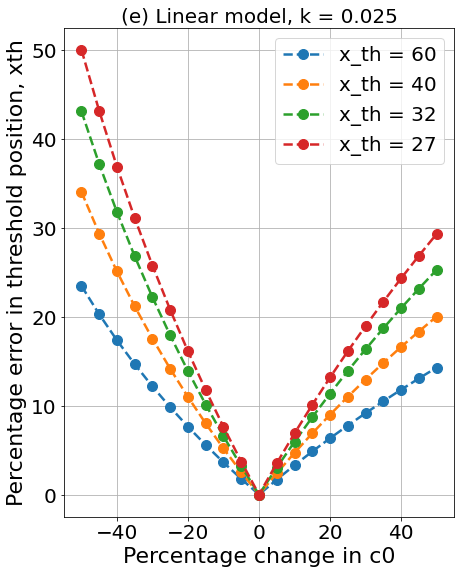

In [121]:
plt.figure(figsize=(7,9))
plt.xlabel('Percentage change in c0')
plt.ylabel('Percentage error in threshold position, xth')
plt.title(f'(e) Linear model, k = 0.025')
plt.grid(True)
for i in linearchanges:
        plt.plot(np.arange(-50,55,5), i[1], marker='o', markersize=10, linestyle='dashed', linewidth=2.5, label=f'x_th = {int(i[0])}')

plt.legend()
plt.show()

In [116]:
#####################################################
# QUESTION 5 - varying the threshold (self-enhanced)
#####################################################

# Adapted from earlier
# Define different system parameters for the system with self enhanced degradation according to question
d_self7 = 10              # Diffusion coefficient
k0_self7 = 0.000075       # Degradation rate prefactor
c0_self7 = 5000          # Pinned concentration at x = 0
L_all7 = 100            # Tissue size
# Define simulation parameters as already provided
Nx = 201           # Number of spatial (x) gridpoints
tMax = 100000      # Maximum time
thresholdSS = 1e-8 # Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state

x_all7 = np.linspace(0, L_all7, Nx) # From question 1
#conc_linear7 = Solve(d_linear7, k_linear7, c0_linear7, L_all7, Nx, tMax, thresholdSS)

def selfenhancedchange(Cth):
    conc_selfen7 = SolveNonLinearDeg(d_self7, k0_self7, c0_self7, Nx, tMax, L_all7, thresholdSS)
    xThresh_selfen_true7 = findXThresh(Cth, x_all7, conc_selfen7)
    selfen_percent_error7 = []
    for i in np.arange(0.5,1.55,0.05):
        conc_selfen7_2 = SolveNonLinearDeg(d_self7, k0_self7, i*c0_self7, Nx, tMax, L_all7, thresholdSS) 
        xThresh_selfen7 = findXThresh(Cth, x_all7, conc_selfen7_2)
        selfen_percent_error7.append(100*(abs(xThresh_selfen7 - xThresh_selfen_true7)/xThresh_selfen_true7))
    return xThresh_selfen_true7, selfen_percent_error7

In [117]:
values2 = [250, 650, 1000, 1250]
selfenchanges = []
for i in values2:
    selfenchanges.append(selfenhancedchange(i))

Steady state reached at t = 618.2260327357756 s
Steady state reached at t = 688.249707374171 s
Steady state reached at t = 677.2082861935786 s
Steady state reached at t = 667.5612420034328 s
Steady state reached at t = 659.039744139787 s
Steady state reached at t = 651.4250058497778 s
Steady state reached at t = 644.5732111522714 s
Steady state reached at t = 638.3593262632563 s
Steady state reached at t = 632.6833261861136 s
Steady state reached at t = 627.4764169330318 s
Steady state reached at t = 622.6760728066415 s
Steady state reached at t = 618.2260327357756 s
Steady state reached at t = 614.0887659276 s
Steady state reached at t = 610.2205252084469 s
Steady state reached at t = 606.6025166543301 s
Steady state reached at t = 603.2034901838579 s
Steady state reached at t = 599.9984420642649 s
Steady state reached at t = 596.9686112625593 s
Steady state reached at t = 594.1077060862116 s
Steady state reached at t = 591.3907491045009 s
Steady state reached at t = 588.805232218632 

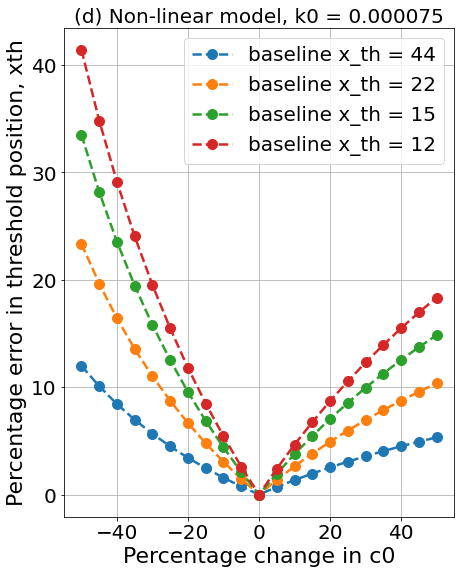

In [118]:
plt.figure(figsize=(7,9))
plt.xlabel('Percentage change in c0')
plt.ylabel('Percentage error in threshold position, xth')
plt.title('(d) Non-linear model, k0 = 0.000075')
plt.grid(True)
for i in selfenchanges:
        plt.plot(np.arange(-50,55,5), i[1], marker='o', markersize=10, linestyle='dashed', linewidth=2.5, label=f'baseline x_th = {int(i[0])}')

plt.legend()
plt.show()

In [ ]:
########################################
# QUESTION 6 - second threshold
########################################

first_threshold = 700 # set accordingly
second_threshold = 276

# Set parameters
k_flinear = 0.05
k0_f = 0.00005
d_f = 10
c0_f = 5000
L_f = 100
Nx = 201           # Number of spatial (x) gridpoints
tMax = 100000      # Maximum time
thresholdSS = 1e-8 # Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state

# Define x
x_f = np.linspace(0, L_f, Nx)

# Solve linear baseline & find x positions
#conc_lin_base = Solve(d_f, k_flinear, c0_f, L_f, Nx, tMax, thresholdSS)
#first_x_lin = findXThresh(first_threshold, x_f, conc_lin_base)
#second_x_lin = findXThresh(second_threshold, x_f, conc_lin_base)

# Solve non-linear
conc_self_base = SolveNonLinearDeg(d_f, k0_f, c0_f, Nx, tMax, L_f, thresholdSS)
first_x_nonlin = findXThresh(first_threshold, x_f, conc_self_base)
second_x_nonlin = findXThresh(second_threshold, x_f, conc_self_base)
print(first_x_nonlin)
print(second_x_nonlin)

In [ ]:
# Plot la tricolore
plt.figure(figsize=(10,6))
plt.plot(x_f, conc_self_base, color='black')
plt.fill_between(x_f, conc_self_base, color='lightblue', alpha=1, where=(x >= 0) & (x <= int(first_x_nonlin)))
plt.fill_between(x_f, conc_self_base, color='white', alpha=0.5, where=(x > int(first_x_nonlin)) & (x <= int(second_x_nonlin)))
plt.fill_between(x_f, conc_self_base, color='red', alpha=1, where=(x > int(second_x_nonlin)) & (x <= 100))
plt.xlim(0,100)
plt.ylim(0,None)
plt.xlabel('Position ($\mu m$)')
plt.ylabel('Conc ($mol \ \mu m^{-3})$')
plt.title(f'Thresholds at x = {int(first_x_nonlin)} and {int(second_x_nonlin)} for non-linear degradation')
plt.show()

print('Positional information - ratio of cell type 1 : cell type 2 : cell type 3')
print(f'Baseline ratio {int(first_x_nonlin)} : {int(second_x_nonlin)-int(first_x_nonlin)} : {100-int(second_x_nonlin)}')

In [ ]:
def frenchflag(modeltype, first_threshold, second_threshold):
    if modeltype == 'linear':
        conc_lin_base = Solve(d_f, k_flinear, c0_f, L_f, Nx, tMax, thresholdSS)
        first_x_lin_truth = findXThresh(first_threshold, x_f, conc_lin_base)
        second_x_lin_truth = findXThresh(second_threshold, x_f, conc_lin_base)
        first_ratio_truth = first_x_lin_truth / (second_x_lin_truth - first_x_lin_truth)
        second_ratio_truth = (second_x_lin_truth - first_x_lin_truth) / (100 - second_x_lin_truth)
        percent_error1 = []
        percent_error2 = []
        for i in np.arange(0.5,1.55,0.05):
            conc_lin = Solve(d_f, k_flinear, i*c0_f, L_f, Nx, tMax, thresholdSS)
            first_x_lin = findXThresh(first_threshold, x_f, conc_lin)
            second_x_lin = findXThresh(second_threshold, x_f, conc_lin)
            first_ratio = first_x_lin / (second_x_lin - first_x_lin)
            second_ratio = (second_x_lin - first_x_lin) / (100 - second_x_lin)
            percent_error1.append(100*(abs(first_ratio - first_ratio_truth)/first_ratio_truth))
            percent_error2.append(100*(abs(second_ratio - second_ratio_truth)/second_ratio_truth))
    
    if modeltype == 'nonlinear':
        conc_self_base = SolveNonLinearDeg(d_f, k0_f, c0_f, Nx, tMax, L_f, thresholdSS)
        first_x_nonlin_truth = findXThresh(first_threshold, x_f, conc_self_base)
        second_x_nonlin_truth = findXThresh(second_threshold, x_f, conc_self_base)
        first_ratio_truth = first_x_nonlin_truth / (second_x_nonlin_truth - first_x_nonlin_truth)
        second_ratio_truth = (second_x_nonlin_truth - first_x_nonlin_truth) / (100 - second_x_nonlin_truth)
        percent_error1 = []
        percent_error2 = []
        for i in np.arange(0.5,1.55,0.05):
            conc_nonlin = SolveNonLinearDeg(d_f, k0_f, i*c0_f, Nx, tMax, L_f, thresholdSS)
            first_x_nonlin = findXThresh(first_threshold, x_f, conc_nonlin)
            second_x_nonlin = findXThresh(second_threshold, x_f, conc_nonlin)
            first_ratio = first_x_nonlin / (second_x_nonlin - first_x_nonlin)
            second_ratio = (second_x_nonlin - first_x_nonlin) / (100 - second_x_nonlin)
            percent_error1.append(100*(abs(first_ratio - first_ratio_truth)/first_ratio_truth))
            percent_error2.append(100*(abs(second_ratio - second_ratio_truth)/second_ratio_truth))
    
    return percent_error1, percent_error2

In [ ]:
#values3 = [475, 44, 136, 25, 850, 25, 850, 136] # linear
values3 = [500, 185, 276, 160, 700, 160, 700, 276]
linear1 = frenchflag('nonlinear', values3[0], values3[1]) # baseline
linear2 = frenchflag('nonlinear', values3[2], values3[3]) # big blue
linear3 = frenchflag('nonlinear', values3[4], values3[5]) # big white
linear4 = frenchflag('nonlinear', values3[6], values3[7]) # big red

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(-50,55,5), linear1[0], color='green', marker='o', markersize=10, ls='dashed', label='Equal')
plt.plot(np.arange(-50,55,5), linear2[0], color='blue', marker='o', markersize=10, ls='dashed', label='Half blue')
plt.plot(np.arange(-50,55,5), linear3[0], color='black', marker='o', markersize=10, ls='dashed', label='Half white')
plt.plot(np.arange(-50,55,5), linear4[0], color='red', marker='o', markersize=10, ls='dashed', label='Half red')
plt.xlabel('Percentage change in c0')
plt.ylabel('Percentage error in ratio')
plt.title('Cell type 1 : cell type 2')
plt.grid(True)
plt.ylim(0,40)
plt.legend()
plt.show()

plt.figure(figsize=(8,8))
plt.plot(np.arange(-50,55,5), linear1[1], color='green', marker='o', markersize=10, ls='dashed', label='Equal')
plt.plot(np.arange(-50,55,5), linear2[1], color='blue', marker='o', markersize=10, ls='dashed', label='Half blue')
plt.plot(np.arange(-50,55,5), linear3[1], color='black', marker='o', markersize=10, ls='dashed', label='Half white')
plt.plot(np.arange(-50,55,5), linear4[1], color='red', marker='o', markersize=10, ls='dashed', label='Half red')
plt.xlabel('Percentage change in c0')
plt.ylabel('Percentage error in ratio')
plt.title('Cell type 2 : cell type 3')
plt.grid(True)
plt.ylim(0,40)
plt.legend()
plt.show()

In [ ]:
# Define system parameters
d = 10             # Diffusion coefficient
k1 = 0.075  
k2 = 0.025 # Degradation rate
c0 = 1000          # Pinned concentration at x = 0
L = 50            # Tissue size

# Define simulation parameters
Nx = 201           # Number of spatial (x) gridpoints
tMax = 100000      # Maximum time
thresholdSS = 1e-8 # Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state

# Define x-axis for plotting
x = np.linspace(0, L, Nx)

# Calculate the steady state concentration
conc = Solve(d, k1, c0, L, Nx, tMax, thresholdSS)
conc2 = Solve(d, k2, conc[-1], L, Nx, tMax, thresholdSS)

# Plot results
fig, ax = plt.subplots() # Initiate the figure and axes
plot(fig, ax, x, conc, L, xLabel = 'Position/$\mu m$', yLabel = 'Conc/$mol \mu m^{-3}$', colour = 'royalblue', linelabel = 'k1 = 0.075 s-1')
plot(fig, ax, x, conc, L, xLabel = 'Position/$\mu m$', yLabel = 'Conc/$mol \mu m^{-3}$', colour = 'coral', linelabel = 'k2 = 0.025 s-1');

In [78]:
###########################################################################################################################
## MARCH-APRIL 2024
### Varying the degradation rate

# Define system parameters according to question
d_A = 1             # Diffusion coefficient
k_A = 0.05           # Degradation rate
c0_A = 5000          # Pinned concentration at x = 0
L_A = 100            # Tissue size

# Define different system parameters for the system with self enhanced degradation according to question
k0_self_A = 0.00005       # Degradation rate prefactor

# Define simulation parameters as already provided
Nx = 201           # Number of spatial (x) gridpoints
tMax = 100000      # Maximum time
thresholdSS = 1e-8 # Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state

# What is the "true" threshold position?
x_A = np.linspace(0, L_A, Nx) # From question 1

def varyk_linear(Cth):
    # Find true baseline threshold for linear
    linear_conc = Solve(d_A, k_A, c0_A, L_A, Nx, tMax, thresholdSS)
    xth_linear = findXThresh(Cth, x_A, linear_conc)
    print(xth_linear)
    # Find percentage errors after varying k
    linear_error = []
    for i in np.arange(0.5, 1.55, 0.05):
        linear_conc2 = Solve(d_A, i*k_A, c0_A, L_A, Nx, tMax, thresholdSS)
        xth_linear2 = findXThresh(Cth, x_A, linear_conc2)
        linear_error.append(100*(abs(xth_linear2 - xth_linear)/xth_linear))
    
    return xth_linear, linear_error

def varyk_nonlinear(Cth):
    # Find true baseline threshold for self-enhanced model 2
    self_conc = SolveNonLinearDeg(d_A, k0_self_A, c0_A, Nx, tMax, L_A, thresholdSS)
    xth_self = findXThresh(Cth, x_A, self_conc)
    # Find percentage errors after varying k
    self_error = []
    for i in np.arange(0.5, 1.55, 0.05):
        self_conc2 = SolveNonLinearDeg(d_A, i*k0_self_A, c0_A, Nx, tMax, L_A, thresholdSS)
        xth_self2 = findXThresh(Cth, x_A, self_conc2)
        self_error.append(100*(abs(xth_self2 - xth_self)/xth_self))
    
    return xth_self, self_error

def varyk_nonlinear_q(Cth):
    # Find true baseline threshold for self-enhanced model 3
    q2self_conc = SolveNewExponentNonLinear(d_A, k0_self_A, 500, Nx, tMax, L_A, thresholdSS, 2)
    xth_q2self = findXThresh(Cth, x_A, q2self_conc)
    
    q3self_conc = SolveNewExponentNonLinear(d_A, k0_self_A, 500, Nx, tMax, L_A, thresholdSS, 3)
    xth_q3self = findXThresh(Cth, x_A, q3self_conc)
    # Find percentage errors after varying k
    q2self_error = []
    q3self_error = []
    for i in np.arange(0.5, 1.55, 0.05):
        q2self_conc2 = SolveNewExponentNonLinear(d_A, i*k0_self_A, 500, Nx, tMax, L_A, thresholdSS, 2)
        xth_q2self2 = findXThresh(Cth, x_A, q2self_conc2)
        q2self_error.append(100*(abs(xth_q2self2 - xth_q2self)/xth_q2self))
        
        q3self_conc2 = SolveNewExponentNonLinear(d_A, i*k0_self_A, 500, Nx, tMax, L_A, thresholdSS, 3)
        xth_q3self2 = findXThresh(Cth, x_A, q3self_conc2)
        q3self_error.append(100*(abs(xth_q3self2 - xth_q3self)/xth_q3self))

    return xth_q2self, q2self_error, xth_q3self, q3self_error

def varyk_teimouri(Cth, k1, k2):
    #ks = [0.025, 0.075, 0.0125, 0.0875, 0.0375, 0.0625]
    conc1 = Solve(d_A, k1, 5000, 50, 101, tMax, thresholdSS)
    conc2 = Solve(d_A, k2, conc1[-1], 50, 101, tMax, thresholdSS)
    conc = np.array(np.concatenate((conc1, conc2)))
    print(len(conc))
    xth = findXThresh(Cth, x_A, conc)
    
    conc3 = Solve(d_A, k2, 5000, 50, 101, tMax, thresholdSS)
    conc4 = Solve(d_A, k1, conc3[-1], 50, 101, tMax, thresholdSS)
    concB = np.concatenate((conc3, conc4))
    xthB = findXThresh(Cth, x_A, concB)
    
    percentage_diff = 100*(abs(xthB - xth) / xth)
    
    print(f'For k1 = {k1} and k2 = {k2}, the percentage difference in x at concentration {Cth} is {percentage_diff}%')
    
    return percentage_diff

In [93]:
valuesA_linear = [0.05, 0.5, 150, 750] # corresponding to 80, 60, 40, 20
changesA_linear = []
for i in valuesA_linear:
    changesA_linear.append(varyk_linear(i))

Steady state reached at t = 269.595015576324 s
51.51109988485084
Steady state reached at t = 513.4477379095164 s
Steady state reached at t = 470.004679457183 s
Steady state reached at t = 433.4996880848409 s
Steady state reached at t = 402.4949321690317 s
Steady state reached at t = 375.67820392890553 s
Steady state reached at t = 352.3616523772408 s
Steady state reached at t = 331.79551122194516 s
Steady state reached at t = 313.60448807854135 s
Steady state reached at t = 297.35119975070114 s
Steady state reached at t = 282.78548060445553 s
Steady state reached at t = 269.595015576324 s
Steady state reached at t = 257.5922753465193 s
Steady state reached at t = 246.65213329180943 s
Steady state reached at t = 236.6495407130624 s
Steady state reached at t = 227.39726027397262 s
Steady state reached at t = 218.89494163424123 s
Steady state reached at t = 211.0177404295051 s
Steady state reached at t = 203.76536486696747 s
Steady state reached at t = 196.9508400746733 s
Steady state rea

In [97]:
valuesA_nonlinear = [50, 250, 750, 1500] # corresponding to 80, 60, 40, 20
valuesA_nonlinear_q = [200, 250, 300, 350]
changesA_nonlinear = []
changesA_nonlinear2 = []
changesA_nonlinear3 = []
for i in valuesA_nonlinear:
    changesA_nonlinear.append(varyk_nonlinear(i))

Steady state reached at t = 4125.969230769231 s
Steady state reached at t = 4418.356589147287 s
Steady state reached at t = 4374.407436096049 s
Steady state reached at t = 4335.417956656347 s
Steady state reached at t = 4300.510440835266 s
Steady state reached at t = 4268.933539412674 s
Steady state reached at t = 4240.123552123552 s
Steady state reached at t = 4213.703703703704 s
Steady state reached at t = 4189.360061680802 s
Steady state reached at t = 4166.718027734976 s
Steady state reached at t = 4145.6505003849115 s
Steady state reached at t = 4125.969230769231 s
Steady state reached at t = 4107.486548808609 s
Steady state reached at t = 4090.076804915515 s
Steady state reached at t = 4073.6147352264006 s
Steady state reached at t = 4058.036809815951 s
Steady state reached at t = 4043.2183908045977 s
Steady state reached at t = 4029.157733537519 s
Steady state reached at t = 4015.730680948738 s
Steady state reached at t = 4002.9357798165133 s
Steady state reached at t = 3990.649

In [99]:
valuesA_linear_teimouri = [0.05, 0.5, 150, 750]
ks = [0.025, 0.075, 0.0125, 0.0875, 0.0375, 0.0625]
for i in valuesA_linear_teimouri:
    varyk_teimouri(i, ks[2], ks[3])
    varyk_teimouri(i, ks[0], ks[1])
    varyk_teimouri(i, ks[4], ks[5])

Steady state reached at t = 962.9352068696331 s
Steady state reached at t = 159.8756798756799 s
202
Steady state reached at t = 159.8756798756799 s
Steady state reached at t = 962.9352068696331 s
For k1 = 0.0125 and k2 = 0.0875, the percentage difference in x at concentration 0.05 is 46.55023422330238%
Steady state reached at t = 513.0733229329173 s
Steady state reached at t = 184.696734059098 s
202
Steady state reached at t = 184.696734059098 s
Steady state reached at t = 513.0733229329173 s
For k1 = 0.025 and k2 = 0.075, the percentage difference in x at concentration 0.05 is 36.39706558578754%
Steady state reached at t = 352.4240062353858 s
Steady state reached at t = 218.95719844357976 s
202
Steady state reached at t = 218.95719844357976 s
Steady state reached at t = 352.4240062353858 s
For k1 = 0.0375 and k2 = 0.0625, the percentage difference in x at concentration 0.05 is 22.74500810327181%
Steady state reached at t = 962.9352068696331 s
Steady state reached at t = 159.8756798756

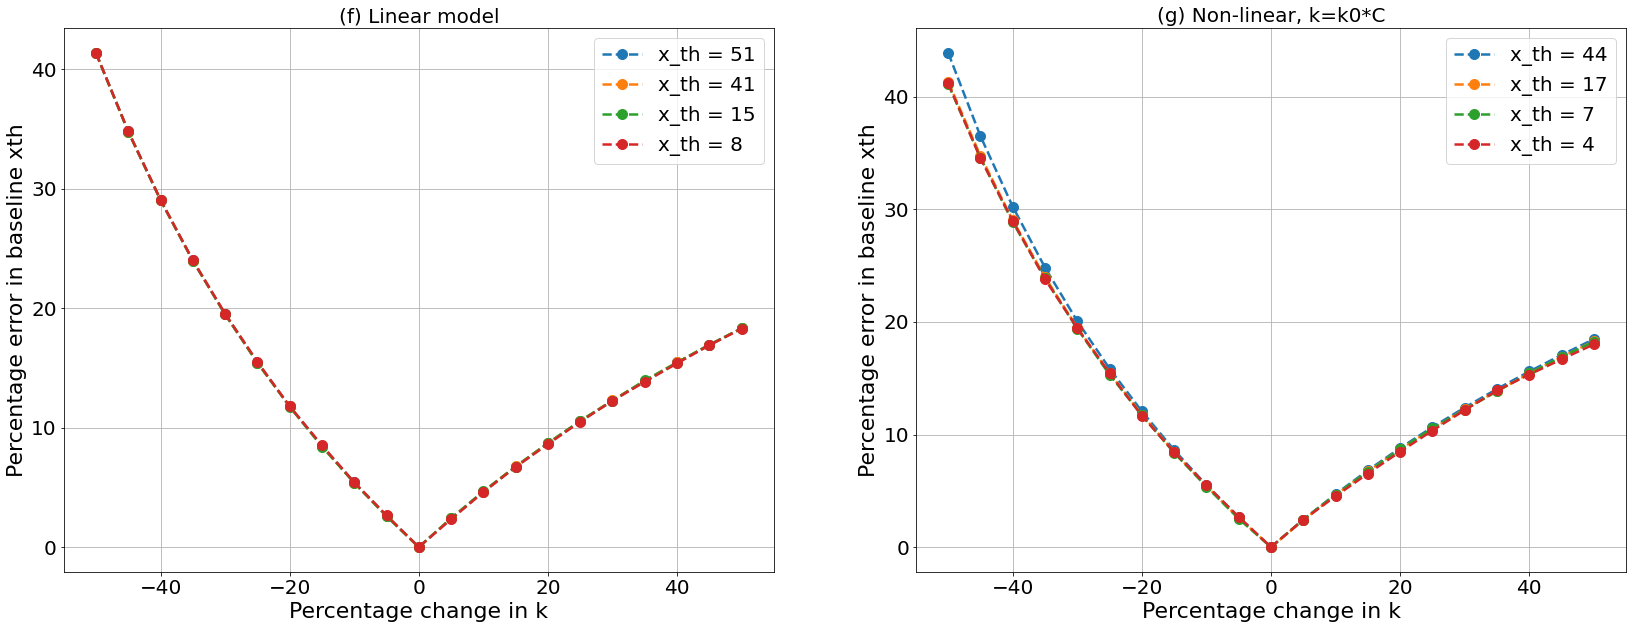

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(28,10))
for i in changesA_linear:
    ax[0].plot(np.arange(-50,55,5), i[1], marker='o', markersize=10, linestyle='dashed', linewidth=2.5, label=f'x_th = {int(i[0])}')
    ax[0].set_xlabel('Percentage change in k')
    ax[0].set_ylabel('Percentage error in baseline xth')
    ax[0].set_title('(f) Linear model')
    ax[0].legend()
    ax[0].grid(True)
for i in changesA_nonlinear:
    ax[1].plot(np.arange(-50,55,5), i[1], marker='o', markersize=10, linestyle='dashed', linewidth=2.5, label=f'x_th = {int(i[0])}')
    ax[1].set_xlabel('Percentage change in k')
    ax[1].set_ylabel('Percentage error in baseline xth')
    ax[1].set_title('(g) Non-linear, k=k0*C')
    ax[1].legend()
    ax[1].grid(True)
for i in changesA_nonlinear2:
    ax[2].plot(np.arange(-50,55,5), i[1], marker='o', markersize=10, linestyle='dashed', linewidth=2.5, label=f'x_th = {int(i[0])}')
    ax[2].set_xlabel('Percentage change in k')
    ax[2].set_ylabel('Percentage error in baseline xth')
    ax[2].set_title('(c) Non-linear, k=k0*C^2')
    ax[2].legend()
    ax[2].grid(True)
for i in changesA_nonlinear3:
    ax[3].plot(np.arange(-50,55,5), i[3], marker='o', markersize=10, linestyle='dashed', linewidth=2.5, label=f'x_th = {int(i[2])}')
    ax[3].set_xlabel('Percentage change in k')
    ax[3].set_ylabel('Percentage error in baseline xth')
    ax[3].set_title('(d) Non-linear, k=k0*C^3')
    ax[3].legend()
    ax[3].grid(True)